## 指数関数型シナプスモデル

In [1]:
using Plots

In [9]:
td, tr = 2e-3, 2e-3 # synaptic decay time, synaptic rise time (sec)
# trが小さいほど単一指数関数モデルに近づく
dt, T = 5e-5, 0.1 # タイムステップ, シミュレーション時間 (sec)
#dt, T = 0.05, 1 # タイムステップ, シミュレーション時間 (sec)
nt = Int(T/dt) # シミュレーションの総ステップ

# 単一指数関数型シナプス
r_single = zeros(nt)
for t in 1:nt-1
    spike = ifelse(t == 1, 1, 0)
    r_single[t+1] = r_single[t]*(1-dt/td) + spike/td
    #r_single[t+1] = r_single[t]*exp(-dt/td) + spike/td
end

# 二重指数関数型シナプス
r_double, hr = zeros(nt), zeros(nt)
for t in 1:nt-1
    spike = ifelse(t == 1, 1, 0)
    r_double[t+1] = r_double[t]*(1-dt/tr) + hr[t]*dt
    hr[t+1] = hr[t]*(1-dt/td) + spike/(tr*td)
    #r_double[t+1] = r_double[t]*exp(-dt/tr) + hr[t]*dt
    #hr[t+1] = hr[t]*exp(-dt/td) + spike/(tr*td)
end 

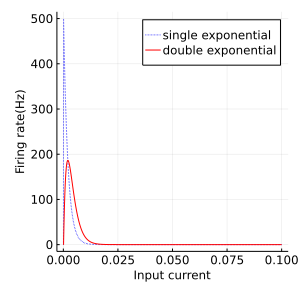

In [10]:
p1 = plot((1:nt)*dt, r_single, color="blue",linestyle=:dot,label="single exponential")
p1 = plot!((1:nt)*dt, r_double, color="red",label="double exponential")
plot(p1 , guidefont=font(8),
xlabel = "Input current", 
ylabel = "Firing rate(Hz)",legend=true, size=(300,300))

## 動力学モデル

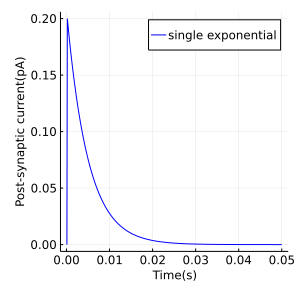

In [25]:
dt = 1e-4
α, β = 1/5e-4, 1/5e-3
T=0.05 # (sec)
nt = Int(T/dt)

r = zeros(nt)

for t in 1:nt-1
    # spike...シナプス前細胞が発火したときにインパルス的に1だけ増加させる
    spike = ifelse(t == 1 ,1, 0)
    r[t+1] = r[t] + dt * (α*spike*(1-r[t]) - β*r[t])
end

time = (1:nt)*dt

p1 = plot(time, r, color="blue",label="single exponential")
plot(p1 , guidefont=font(8),
xlabel = "Time(s)", 
ylabel = "Post-synaptic current(pA)",legend=true, size=(300,300))

## HHモデルのシナプスモデル

In [26]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack

@kwdef struct HHParameter{FT}
    Cm::FT = 1.0 # 膜容量(uF/cm^2)
    gNa::FT = 120.0 # Na+ の最大コンダクタンス(mS/cm^2)
    gK::FT = 36.0 # K+ の最大コンダクタンス(mS/cm^2)
    gL::FT = 0.3 # 漏れイオンの最大コンダクタンス(mS/cm^2)
    ENa::FT = 50.0 # Na+ の平衡電位(mV)
    EK::FT = -77.0 # K+ の平衡電位(mV)
    EL::FT = -54.387 #漏れイオンの平衡電位(mV)
    tr::FT = 0.5 # ms
    td::FT = 8.0 # ms
    invtr::FT = 1.0 / tr
    invtd::FT = 1.0 / td
    v0::FT = -20.0 # mV
end

@kwdef mutable struct HH{FT}
    param::HHParameter = HHParameter{FT}()
    N::Int32
    v::Vector{FT} = fill(-65.0, N)
    m::Vector{FT} = fill(0.05, N)
    h::Vector{FT} = fill(0.6, N)
    n::Vector{FT} = fill(0.32, N)
    r::Vector{FT} = zeros(N)
end

function updateHH!(variable::HH, param::HHParameter, I::Vector, dt)
    @unpack N, v, m, h, n, r = variable
    @unpack Cm, gNa, gK, gL, ENa, EK, EL, tr, td, invtr, invtd, v0= param
    @inbounds for i = 1:N
        m[i] += dt * ((0.1(v[i]+40.0)/(1.0 - exp(-0.1(v[i]+40.0))))*(1.0 - m[i]) - 4.0exp(-(v[i]+65.0) / 18.0)*m[i])
        h[i] += dt * ((0.07exp(-0.05(v[i]+65.0)))*(1.0 - h[i]) - 1.0/(1.0 + exp(-0.1(v[i]+35.0)))*h[i])
        n[i] += dt * ((0.01(v[i]+55.0)/(1.0 - exp(-0.1(v[i]+55.0))))*(1.0 - n[i]) - (0.125exp(-0.0125(v[i]+65)))*n[i])
        v[i] += dt / Cm * (I[i] - gNa * m[i]^3 * h[i] * (v[i] - ENa) - gK * n[i]^4 * (v[i] - EK) - gL * (v[i] - EL))
        r[i] += dt * ((invtr - invtd) * (1.0 - r[i])/(1.0 + exp(-v[i] + v0)) - r[i] * invtd)
    end
end

updateHH! (generic function with 1 method)

In [27]:
T = 50 # ms
dt = 0.01f0 # ms
nt = Int32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(5f0 * ((t .> 10) - (t .> 15)), 1, N)  # injection current

# 記録用
varr, rarr = zeros(Float32, nt, N), zeros(Float32, nt, N)
# modelの定義
neurons = HH{Float32}(N=N)

# simulation
@time for i = 1:nt
    updateHH!(neurons, neurons.param, I[i, :], dt)
    varr[i, :], rarr[i, :] = neurons.v, neurons.r
end

  0.084683 seconds (438.54 k allocations: 21.952 MiB)


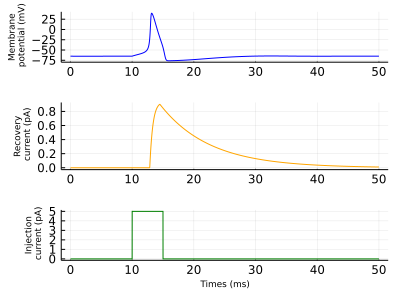

In [31]:
p1 = plot(t, varr[:, 1], color="blue")
labellist=["orange" "blue" "green"]
p2 = plot(t, rarr[:, 1], color=labellist[1])
p3 = plot(t, I[:, 1], color="green")
plot(p1, p2, p3,
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Recovery\n current (pA)" "Injection\n current (pA)"],
    layout = grid(3, 1, heights=[0.3, 0.4, 0.3]), guidefont=font(6), legend=false, size=(400,300))